In [29]:
# import library
import pandas as pd 
import numpy as np
import scipy
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

### 1. Cosine similarity

In [2]:
# load an preview data
Visim400 = pd.read_csv('datasets/ViSim-400/Visim-400.txt', sep='\t')
Visim400.head()

,Word1,Word2,POS,Sim1,Sim2,STD
0,biến,ngập,V,3.13,5.22,0.72
1,nhà_thi_đấu,nhà,N,3.07,5.12,1.18
2,động,tĩnh,V,0.60,1.00,0.95
3,khuyết,ưu,N,0.20,0.33,0.40
4,cõi_tục,cõi_âm,N,0.60,1.00,0.95


In [3]:
# load pre-train model
with open("W2V_150.txt") as file:
    data = file.readlines()
len(data)

77023

In [4]:
# remove \n at the end
for i in range(len(data)):
    data[i] = data[i][:-1]

In [5]:
# convert data from string to float64
data_dict = dict()
for i in range(len(data)):
    split_data = data[i].split()
    data_dict[split_data[0]] = np.array(split_data[1:]).astype('float64')

In [6]:
# function for calculating cosine similarity
def cosine_similarity(a, b):
    nominator = np.dot(a, b)
    
    a_norm = np.sqrt(np.sum(a**2))
    b_norm = np.sqrt(np.sum(b**2))
    
    denominator = a_norm * b_norm
    
    cosine_similarity = nominator / denominator
    
    return cosine_similarity

In [7]:
# function for selecting trained words
def selectTrainedWords(inData):
    select = []
    for i in np.arange(len(inData)):
        if inData.loc[i,'Word1'] in data_dict.keys() and inData.loc[i,'Word2'] in data_dict.keys():
            select.extend([True])
        else:
            select.extend([False])
    outData = inData[select].copy()
    outData.index = np.arange(len(outData))
    return outData

In [8]:
# select trained words for Visim400
print("Kích thước của Visim400 trước khi lọc: ", Visim400.shape)
subVisim400 = selectTrainedWords(Visim400)
print("Kích thước của Visim400 sau khi lọc: ", subVisim400.shape)

Kích thước của Visim400 trước khi lọc:  (400, 6)
Kích thước của Visim400 sau khi lọc:  (344, 6)


In [9]:
# caculate cosine similarity for each pairs
cos_sim = []
for i in range(len(subVisim400)):
    cos_sim.extend([cosine_similarity(data_dict[subVisim400.loc[i,'Word1']],
                      data_dict[subVisim400.loc[i,'Word2']])])
subVisim400['CosSim'] = cos_sim
subVisim400.head()

,Word1,Word2,POS,Sim1,Sim2,STD,CosSim
0,biến,ngập,V,3.13,5.22,0.72,-0.004912
1,nhà_thi_đấu,nhà,N,3.07,5.12,1.18,0.082523
2,động,tĩnh,V,0.60,1.00,0.95,0.277086
3,khuyết,ưu,N,0.20,0.33,0.40,0.176799
4,thủ_pháp,biện_pháp,N,4.13,6.88,1.26,0.402366


In [10]:
# Calculate correlation of CosSim and Sim1 columns
print(" Pearson correlation coefficient: ", stats.pearsonr(subVisim400['CosSim'],subVisim400['Sim1']))
print(" Spearman's rank correlation coefficient: ", stats.spearmanr(subVisim400['CosSim'],subVisim400['Sim1']))

 Pearson correlation coefficient:  (0.4468477986391989, 2.7432767587469776e-18)
 Spearman's rank correlation coefficient:  SpearmanrResult(correlation=0.4077568887734169, pvalue=3.2645624595200806e-15)


In [11]:
# Calculate correlation of CosSim and Sim2 columns
print(" Pearson correlation coefficient: ", stats.pearsonr(subVisim400['CosSim'],subVisim400['Sim2']))
print(" Spearman's rank correlation coefficient: ", stats.spearmanr(subVisim400['CosSim'],subVisim400['Sim2']))

 Pearson correlation coefficient:  (0.44681975508807675, 2.7581737626379143e-18)
 Spearman's rank correlation coefficient:  SpearmanrResult(correlation=0.4077568887734169, pvalue=3.2645624595200806e-15)


### 2. K-nearest words

In [12]:
cos_sim = []
word = 'khuyết' # change here
k = 2 # change here
for i, w in enumerate(list(data_dict.keys())[2:]): ## bỏ giá trị ['77021', '150']
    cos_sim.append([w, cosine_similarity(data_dict[word],
                          data_dict[w])])
cos_sim = pd.DataFrame(cos_sim, columns = ['words', 'CosSim'])
cos_sim = cos_sim.sort_values(by='CosSim', ascending = False)

print(f'{k} từ gần nghĩa với {word} là :')
for i in range(k):
    print(cos_sim['words'].values[1+i])

2 từ gần nghĩa với khuyết là :
cháy_đen
cắt_xén


### 3. Synonym-antonym classification

In [13]:
# read synonym data
synonym = pd.read_csv('antonym-synonym set/Synonym_vietnamese.txt', sep=' ', header = None)
synonym.columns = ['Word1','Word2']
synonym.head()

,Word1,Word2
0,a_dua,a_tòng
1,a_dua,vào_hùa
2,a_ma_tơ,tài_tử
3,a_tòng,vào_hùa
4,à_ơi,ạ_ơi


In [14]:
# select not-null rows
print("Kích thước của synonym trước khi lọc: ", synonym.shape)
synonym = selectTrainedWords(synonym)
print("Kích thước của synonym sau khi lọc: ", synonym.shape)

Kích thước của synonym trước khi lọc:  (11562, 2)
Kích thước của synonym sau khi lọc:  (6273, 2)


In [15]:
# read antonym data
antonym = pd.read_csv('antonym-synonym set/Antonym_vietnamese.txt', sep=' ', header = None)
antonym.columns = ['Word1','Word2']
antonym.head()

,Word1,Word2
0,ác,hiền
1,ác,thiện
2,ác_cảm,thiện_cảm
3,ác_độc,hiền_lành
4,ác_độc,hiền_từ


In [16]:
# select not-null rows
print("Kích thước của synonym trước khi lọc: ", antonym.shape)
antonym = selectTrainedWords(antonym)
print("Kích thước của synonym sau khi lọc: ", antonym.shape)

Kích thước của synonym trước khi lọc:  (2000, 2)
Kích thước của synonym sau khi lọc:  (1731, 2)


In [17]:
# calculate cosine similarity for each pairs
# for synonym
cos_sim = []
for i in range(len(synonym)):
    cos_sim.extend([cosine_similarity(data_dict[synonym.loc[i, 'Word1']],
                    data_dict[synonym.loc[i, 'Word2']])])
synonym['CosSim'] = cos_sim
synonym['Label'] = 1

# for antonym
cos_sim = []
for i in range(len(antonym)):
    cos_sim.extend([cosine_similarity(data_dict[antonym.loc[i, 'Word1']],
                    data_dict[antonym.loc[i, 'Word2']])])
antonym['CosSim'] = cos_sim
antonym['Label'] = 0

# merge two datasets
synonym_antonym = pd.concat([synonym, antonym], axis = 0)
synonym_antonym.index = range(len(synonym_antonym))

In [18]:
# split X and y into training and testing sets
from sklearn.model_selection import train_test_split
# import the class
from sklearn.linear_model import LogisticRegression
# import the metrics class
from sklearn import metrics

In [28]:
X_train,X_test,y_train,y_test=train_test_split(synonym_antonym['CosSim'].values,
                                               synonym_antonym['Label'].values,
                                               test_size=0.20,
                                               random_state=42)
# Reshape data either using 
# array.reshape(-1, 1) if your data has a single feature
X_train = X_train.reshape(-1, 1)
X_test = X_test.reshape(-1, 1)

# instantiate the model (using the default parameters)
logreg = LogisticRegression(penalty='l2')

# fit the model with data

logreg.fit(X_train,y_train)

# predict the new data
y_pred=logreg.predict(X_test)

In [20]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[   0,  341],
       [   1, 1259]])

<AxesSubplot:>

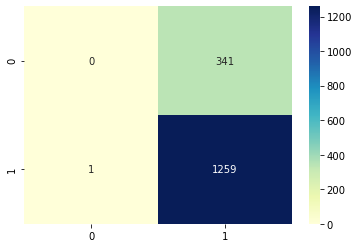

In [37]:
sns.heatmap(cnf_matrix, annot=True, fmt="d", cmap="YlGnBu")

In [27]:
print("Accuracy:", round(metrics.accuracy_score(y_test, y_pred),4))
print("Precision:", round(metrics.precision_score(y_test, y_pred),4))
print("Recall:", round(metrics.recall_score(y_test, y_pred),4))
print("F1-score:", round(metrics.f1_score(y_test, y_pred),4))

Accuracy: 0.7864
Precision: 0.7869
Recall: 0.9992
F1-score: 0.8804
